# WeatherPy: Weather Analysis Based on Latitude (3/1/2018)

Based on this analysis, latitude can only be used to predict temperature and demonstrates no relationship with a city's humidity, cloudiness, or wind speed.

To perform this analysis:
- To ensure a good sample of data, I generated 1,000 random, unique cities around the world using a combination of randomized latitude/longitude pairs and Citipy (to ensure I returned an actual city, not just a location on a map).
- To ensure that I didn't have false positives when determining if a city was a duplicate (for example, Bagdhad, Arizona and Baghdad, Iraq are two very different cities), I used the unique ID that OpenWeatherMap assigns each city to eliminate my dupes.
- I pulled weather data that corresponded to those cities from OpenWeatherMap on 3/1/2018 at approximately 3:00 AM PST.

In [1]:
# -----------------------------------------------------------------------------------
# Step 1: Import the modules 
# -----------------------------------------------------------------------------------
import seaborn as sns
import json
import matplotlib.pyplot as plt
import requests as req
import pandas as pd
import random as rd
from citipy import citipy
from localenv import api_key
from aux import displayProcessingCity, displayFailedCity, continentFromCountry

## City Data

In [2]:
# -----------------------------------------------------------------------------------
# Step 2: Store all our basic API data. I'd use params, but I couldn't get it to work
# with the unique structure of some of these parameters
# -----------------------------------------------------------------------------------

tempUnits = 'Imperial'
openWeatherURL = "http://api.openweathermap.org/data/2.5/weather?"

In [20]:
# -----------------------------------------------------------------------------------
# Step 3: Create a list of non-duplicate cities
# -----------------------------------------------------------------------------------
# create a list that we'll store all our data in
weatherData_list = []
city_list = []

# create dupe checking set
cityDupeChecker = set()

# create counter
i = 0

# create a list of 1500 possible cities (so even if a query fails still have good sample)
while len(cityDupeChecker) < 1500:
    
    # set random lat and long
    latitude = rd.uniform(-90.0,90.0)
    longitude = rd.uniform(-180.0,180.0)
    
    # get city
    city = citipy.nearest_city(latitude,longitude).city_name
    country = citipy.nearest_city(latitude,longitude).country_code
    city_country_pair = f"{city}_{country}"
    
    if city_country_pair not in cityDupeChecker:
        cityDupeChecker.add(city_country_pair)
        
        # try to pull in a random value and add to dupe checker
        city_list.append([city, country])

In [21]:
# -----------------------------------------------------------------------------------
# Step 4: Pull city data from openweatherapi
# -----------------------------------------------------------------------------------
for i in range(len(city_list)):
    
    # get current city and country
    city = city_list[i][0]
    country= city_list[i][1]
        
    # try searching by city + country code
    try:
        response = req.get(f"{openWeatherURL}q={city},{country}&units={tempUnits}&APPID={api_key}").json()
        
        # add information from response to list
        weatherData_list.append({'ID':response['id'],
                                 'City': response['name'],
                                 'Country': country.upper(),
                                 'Continent': continentFromCountry(country.upper()),
                                 'Latitude':response['coord']['lat'],
                                 'Longitude':response['coord']['lon'],
                                 'Humidity (%)':response['main']['humidity'],
                                 'Temperature (Fahrenheit)':response['main']['temp'],
                                 'Wind Speed':response['wind']['speed'],
                                 'Cloudiness':response['clouds']['all'] })
        
        #show city
        #displayProcessingCity(i,response)
    except:    
        try:
            response = req.get(f"{openWeatherURL}q={city}&units={tempUnits}&APPID={api_key}").json()
            
            # add information from response to list
            weatherData_list.append({'ID':response['id'],
                                     'City': response['name'],
                                     'Country': response['main']['sys']['country'].upper(),
                                     'Continent': continentFromCountry(response['main']['sys']['country'].upper()),
                                     'Latitude': response['coord']['lat'],
                                     'Longitude': response['coord']['lon'],
                                     'Humidity (%)':response['main']['humidity'],
                                     'Temperature (Fahrenheit)':response['main']['temp'],
                                     'Wind Speed':response['wind']['speed'],
                                     'Cloudiness':response['clouds']['all']})
                                    
            #show city
            #displayProcessingCity(i,response)
        except:
            #displayFailedCity(i, city, country)
            pass

City #1
City URL: http://api.openweathermap.org/data/2.5/weather?id=1282256
City Name: Hithadhoo
City ID: 1282256
----------------------------------------------------------------------------
City #2
City URL: http://api.openweathermap.org/data/2.5/weather?id=1726449
City Name: Basco
City ID: 1726449
----------------------------------------------------------------------------
City #3
City URL: http://api.openweathermap.org/data/2.5/weather?id=3874787
City Name: Punta Arenas
City ID: 3874787
----------------------------------------------------------------------------
City #4
City URL: http://api.openweathermap.org/data/2.5/weather?id=3395981
City Name: Maceio
City ID: 3395981
----------------------------------------------------------------------------
City #5
City URL: http://api.openweathermap.org/data/2.5/weather?id=6089245
City Name: Norman Wells
City ID: 6089245
----------------------------------------------------------------------------
City #6: FAILED
taolanaro, mg
----------------

City #48
City URL: http://api.openweathermap.org/data/2.5/weather?id=2126199
City Name: Cherskiy
City ID: 2126199
----------------------------------------------------------------------------
City #49
City URL: http://api.openweathermap.org/data/2.5/weather?id=2077963
City Name: Albany
City ID: 2077963
----------------------------------------------------------------------------
City #50
City URL: http://api.openweathermap.org/data/2.5/weather?id=2152659
City Name: Port Macquarie
City ID: 2152659
----------------------------------------------------------------------------
City #51
City URL: http://api.openweathermap.org/data/2.5/weather?id=3863379
City Name: Mar del Plata
City ID: 3863379
----------------------------------------------------------------------------
City #52
City URL: http://api.openweathermap.org/data/2.5/weather?id=3899695
City Name: Ancud
City ID: 3899695
----------------------------------------------------------------------------
City #53
City URL: http://api.openweath

City #94
City URL: http://api.openweathermap.org/data/2.5/weather?id=5859699
City Name: College
City ID: 5859699
----------------------------------------------------------------------------
City #95
City URL: http://api.openweathermap.org/data/2.5/weather?id=3469437
City Name: Bom Jesus da Lapa
City ID: 3469437
----------------------------------------------------------------------------
City #96
City URL: http://api.openweathermap.org/data/2.5/weather?id=3545841
City Name: Nuevitas
City ID: 3545841
----------------------------------------------------------------------------
City #97
City URL: http://api.openweathermap.org/data/2.5/weather?id=3095797
City Name: Kolo
City ID: 3095797
----------------------------------------------------------------------------
City #98
City URL: http://api.openweathermap.org/data/2.5/weather?id=6170031
City Name: Tuktoyaktuk
City ID: 6170031
----------------------------------------------------------------------------
City #99
City URL: http://api.openweat

City #138
City URL: http://api.openweathermap.org/data/2.5/weather?id=5530921
City Name: Snyder
City ID: 5530921
----------------------------------------------------------------------------
City #139
City URL: http://api.openweathermap.org/data/2.5/weather?id=1283285
City Name: Jumla
City ID: 1283285
----------------------------------------------------------------------------
City #140: FAILED
tukrah, ly
----------------------------------------------------------------------------
City #141
City URL: http://api.openweathermap.org/data/2.5/weather?id=4670234
City Name: Alice
City ID: 4670234
----------------------------------------------------------------------------
City #142
City URL: http://api.openweathermap.org/data/2.5/weather?id=1610943
City Name: Den Chai
City ID: 1610943
----------------------------------------------------------------------------
City #143
City URL: http://api.openweathermap.org/data/2.5/weather?id=3943626
City Name: Chivay
City ID: 3943626
---------------------

City #186
City URL: http://api.openweathermap.org/data/2.5/weather?id=1799962
City Name: Xuanwu
City ID: 1799962
----------------------------------------------------------------------------
City #187
City URL: http://api.openweathermap.org/data/2.5/weather?id=3147822
City Name: Gravdal
City ID: 3147822
----------------------------------------------------------------------------
City #188
City URL: http://api.openweathermap.org/data/2.5/weather?id=1140026
City Name: Herat
City ID: 1140026
----------------------------------------------------------------------------
City #189
City URL: http://api.openweathermap.org/data/2.5/weather?id=2120048
City Name: Ust-Nera
City ID: 2120048
----------------------------------------------------------------------------
City #190
City URL: http://api.openweathermap.org/data/2.5/weather?id=1489853
City Name: Tazovskiy
City ID: 1489853
----------------------------------------------------------------------------
City #191
City URL: http://api.openweathermap

City #233
City URL: http://api.openweathermap.org/data/2.5/weather?id=286621
City Name: Salalah
City ID: 286621
----------------------------------------------------------------------------
City #234
City URL: http://api.openweathermap.org/data/2.5/weather?id=5223593
City Name: Newport
City ID: 5223593
----------------------------------------------------------------------------
City #235
City URL: http://api.openweathermap.org/data/2.5/weather?id=3699831
City Name: Aguas Verdes
City ID: 3699831
----------------------------------------------------------------------------
City #236
City URL: http://api.openweathermap.org/data/2.5/weather?id=2163355
City Name: Hobart
City ID: 2163355
----------------------------------------------------------------------------
City #237
City URL: http://api.openweathermap.org/data/2.5/weather?id=2281951
City Name: Sassandra
City ID: 2281951
----------------------------------------------------------------------------
City #238
City URL: http://api.openweathe

City #279
City URL: http://api.openweathermap.org/data/2.5/weather?id=2123814
City Name: Leningradskiy
City ID: 2123814
----------------------------------------------------------------------------
City #280
City URL: http://api.openweathermap.org/data/2.5/weather?id=3451152
City Name: Rio do Sul
City ID: 3451152
----------------------------------------------------------------------------
City #281
City URL: http://api.openweathermap.org/data/2.5/weather?id=1735902
City Name: Sibu
City ID: 1735902
----------------------------------------------------------------------------
City #282
City URL: http://api.openweathermap.org/data/2.5/weather?id=2159220
City Name: Mackay
City ID: 2159220
----------------------------------------------------------------------------
City #283
City URL: http://api.openweathermap.org/data/2.5/weather?id=100926
City Name: Umm Lajj
City ID: 100926
----------------------------------------------------------------------------
City #284
City URL: http://api.openweathe

City #324
City URL: http://api.openweathermap.org/data/2.5/weather?id=2093846
City Name: Kiunga
City ID: 2093846
----------------------------------------------------------------------------
City #325
City URL: http://api.openweathermap.org/data/2.5/weather?id=1072879
City Name: Ankazoabo
City ID: 1072879
----------------------------------------------------------------------------
City #326
City URL: http://api.openweathermap.org/data/2.5/weather?id=553725
City Name: Kamenka
City ID: 553725
----------------------------------------------------------------------------
City #327
City URL: http://api.openweathermap.org/data/2.5/weather?id=884141
City Name: Norton
City ID: 884141
----------------------------------------------------------------------------
City #328
City URL: http://api.openweathermap.org/data/2.5/weather?id=2065594
City Name: Mount Isa
City ID: 2065594
----------------------------------------------------------------------------
City #329
City URL: http://api.openweathermap.o

City #370
City URL: http://api.openweathermap.org/data/2.5/weather?id=2126682
City Name: Bilibino
City ID: 2126682
----------------------------------------------------------------------------
City #371
City URL: http://api.openweathermap.org/data/2.5/weather?id=2629833
City Name: Husavik
City ID: 2629833
----------------------------------------------------------------------------
City #372: FAILED
saleaula, ws
----------------------------------------------------------------------------
City #373
City URL: http://api.openweathermap.org/data/2.5/weather?id=2966778
City Name: Ballina
City ID: 2966778
----------------------------------------------------------------------------
City #374: FAILED
hihifo, to
----------------------------------------------------------------------------
City #375
City URL: http://api.openweathermap.org/data/2.5/weather?id=1490085
City Name: Tarko-Sale
City ID: 1490085
----------------------------------------------------------------------------
City #376: FAILED


City #417
City URL: http://api.openweathermap.org/data/2.5/weather?id=1630789
City Name: Pontianak
City ID: 1630789
----------------------------------------------------------------------------
City #418
City URL: http://api.openweathermap.org/data/2.5/weather?id=2174444
City Name: Bowen
City ID: 2174444
----------------------------------------------------------------------------
City #419
City URL: http://api.openweathermap.org/data/2.5/weather?id=2062276
City Name: Roebourne
City ID: 2062276
----------------------------------------------------------------------------
City #420
City URL: http://api.openweathermap.org/data/2.5/weather?id=6078372
City Name: Moose Factory
City ID: 6078372
----------------------------------------------------------------------------
City #421
City URL: http://api.openweathermap.org/data/2.5/weather?id=3466980
City Name: Caravelas
City ID: 3466980
----------------------------------------------------------------------------
City #422
City URL: http://api.open

City #462
City URL: http://api.openweathermap.org/data/2.5/weather?id=2126710
City Name: Beringovskiy
City ID: 2126710
----------------------------------------------------------------------------
City #463
City URL: http://api.openweathermap.org/data/2.5/weather?id=6157355
City Name: Stonewall
City ID: 6157355
----------------------------------------------------------------------------
City #464
City URL: http://api.openweathermap.org/data/2.5/weather?id=2038650
City Name: Anda
City ID: 2038650
----------------------------------------------------------------------------
City #465
City URL: http://api.openweathermap.org/data/2.5/weather?id=87205
City Name: Darnah
City ID: 87205
----------------------------------------------------------------------------
City #466: FAILED
khonuu, ru
----------------------------------------------------------------------------
City #467: FAILED
gorno-chuyskiy, ru
----------------------------------------------------------------------------
City #468: FAILED

City #507
City URL: http://api.openweathermap.org/data/2.5/weather?id=3855065
City Name: General Roca
City ID: 3855065
----------------------------------------------------------------------------
City #508
City URL: http://api.openweathermap.org/data/2.5/weather?id=3374083
City Name: Bathsheba
City ID: 3374083
----------------------------------------------------------------------------
City #509
City URL: http://api.openweathermap.org/data/2.5/weather?id=3870282
City Name: Talcahuano
City ID: 3870282
----------------------------------------------------------------------------
City #510: FAILED
san quintin, mx
----------------------------------------------------------------------------
City #511
City URL: http://api.openweathermap.org/data/2.5/weather?id=3395503
City Name: Maraba
City ID: 3395503
----------------------------------------------------------------------------
City #512
City URL: http://api.openweathermap.org/data/2.5/weather?id=454584
City Name: Valdemarpils
City ID: 454584

City #552
City URL: http://api.openweathermap.org/data/2.5/weather?id=1809223
City Name: Gushi
City ID: 1809223
----------------------------------------------------------------------------
City #553
City URL: http://api.openweathermap.org/data/2.5/weather?id=2175403
City Name: Blackwater
City ID: 2175403
----------------------------------------------------------------------------
City #554
City URL: http://api.openweathermap.org/data/2.5/weather?id=2120612
City Name: Tigil
City ID: 2120612
----------------------------------------------------------------------------
City #555
City URL: http://api.openweathermap.org/data/2.5/weather?id=2121909
City Name: Poronaysk
City ID: 2121909
----------------------------------------------------------------------------
City #556
City URL: http://api.openweathermap.org/data/2.5/weather?id=2522091
City Name: Alcudia
City ID: 2522091
----------------------------------------------------------------------------
City #557
City URL: http://api.openweatherma

City #597
City URL: http://api.openweathermap.org/data/2.5/weather?id=1708743
City Name: Kinablangan
City ID: 1708743
----------------------------------------------------------------------------
City #598
City URL: http://api.openweathermap.org/data/2.5/weather?id=3879200
City Name: Mulchen
City ID: 3879200
----------------------------------------------------------------------------
City #599
City URL: http://api.openweathermap.org/data/2.5/weather?id=3665202
City Name: Aripuana
City ID: 3665202
----------------------------------------------------------------------------
City #600
City URL: http://api.openweathermap.org/data/2.5/weather?id=2132606
City Name: Samarai
City ID: 2132606
----------------------------------------------------------------------------
City #601
City URL: http://api.openweathermap.org/data/2.5/weather?id=2019488
City Name: Namtsy
City ID: 2019488
----------------------------------------------------------------------------
City #602: FAILED
halalo, wf
------------

City #643: FAILED
ijaki, ki
----------------------------------------------------------------------------
City #644
City URL: http://api.openweathermap.org/data/2.5/weather?id=2064735
City Name: Nhulunbuy
City ID: 2064735
----------------------------------------------------------------------------
City #645
City URL: http://api.openweathermap.org/data/2.5/weather?id=1788457
City Name: Nanding
City ID: 1788457
----------------------------------------------------------------------------
City #646
City URL: http://api.openweathermap.org/data/2.5/weather?id=2514651
City Name: Los Llanos de Aridane
City ID: 2514651
----------------------------------------------------------------------------
City #647
City URL: http://api.openweathermap.org/data/2.5/weather?id=3991622
City Name: Benito Juarez
City ID: 3991622
----------------------------------------------------------------------------
City #648
City URL: http://api.openweathermap.org/data/2.5/weather?id=2510485
City Name: Tias
City ID: 251048

City #687
City URL: http://api.openweathermap.org/data/2.5/weather?id=1494237
City Name: Predivinsk
City ID: 1494237
----------------------------------------------------------------------------
City #688: FAILED
rawannawi, ki
----------------------------------------------------------------------------
City #689
City URL: http://api.openweathermap.org/data/2.5/weather?id=1045114
City Name: Inhambane
City ID: 1045114
----------------------------------------------------------------------------
City #690
City URL: http://api.openweathermap.org/data/2.5/weather?id=921889
City Name: Fomboni
City ID: 921889
----------------------------------------------------------------------------
City #691: FAILED
maridi, sd
----------------------------------------------------------------------------
City #692: FAILED
kegayli, uz
----------------------------------------------------------------------------
City #693
City URL: http://api.openweathermap.org/data/2.5/weather?id=2180737
City Name: Turangi
City 

City #732
City URL: http://api.openweathermap.org/data/2.5/weather?id=2640351
City Name: Peterhead
City ID: 2640351
----------------------------------------------------------------------------
City #733
City URL: http://api.openweathermap.org/data/2.5/weather?id=1848976
City Name: Wajima
City ID: 1848976
----------------------------------------------------------------------------
City #734
City URL: http://api.openweathermap.org/data/2.5/weather?id=5226534
City Name: Brookings
City ID: 5226534
----------------------------------------------------------------------------
City #735
City URL: http://api.openweathermap.org/data/2.5/weather?id=1161724
City Name: Chabahar
City ID: 1161724
----------------------------------------------------------------------------
City #736
City URL: http://api.openweathermap.org/data/2.5/weather?id=2186111
City Name: Ngunguru
City ID: 2186111
----------------------------------------------------------------------------
City #737
City URL: http://api.openweath

City #777
City URL: http://api.openweathermap.org/data/2.5/weather?id=4334720
City Name: Natchitoches
City ID: 4334720
----------------------------------------------------------------------------
City #778
City URL: http://api.openweathermap.org/data/2.5/weather?id=1708130
City Name: Lagawe
City ID: 1708130
----------------------------------------------------------------------------
City #779
City URL: http://api.openweathermap.org/data/2.5/weather?id=3573374
City Name: The Valley
City ID: 3573374
----------------------------------------------------------------------------
City #780
City URL: http://api.openweathermap.org/data/2.5/weather?id=1651103
City Name: Atambua
City ID: 1651103
----------------------------------------------------------------------------
City #781
City URL: http://api.openweathermap.org/data/2.5/weather?id=1626493
City Name: Srandakan
City ID: 1626493
----------------------------------------------------------------------------
City #782
City URL: http://api.openw

City #822
City URL: http://api.openweathermap.org/data/2.5/weather?id=517739
City Name: Novouzensk
City ID: 517739
----------------------------------------------------------------------------
City #823
City URL: http://api.openweathermap.org/data/2.5/weather?id=2188874
City Name: Russell
City ID: 2188874
----------------------------------------------------------------------------
City #824
City URL: http://api.openweathermap.org/data/2.5/weather?id=4099647
City Name: Arkadelphia
City ID: 4099647
----------------------------------------------------------------------------
City #825
City URL: http://api.openweathermap.org/data/2.5/weather?id=2122293
City Name: Ozernovskiy
City ID: 2122293
----------------------------------------------------------------------------
City #826
City URL: http://api.openweathermap.org/data/2.5/weather?id=4005370
City Name: Guadalupe y Calvo
City ID: 4005370
----------------------------------------------------------------------------
City #827
City URL: http:/

City #866
City URL: http://api.openweathermap.org/data/2.5/weather?id=902620
City Name: Mwinilunga
City ID: 902620
----------------------------------------------------------------------------
City #867
City URL: http://api.openweathermap.org/data/2.5/weather?id=2033536
City Name: Yakeshi
City ID: 2033536
----------------------------------------------------------------------------
City #868: FAILED
dianopolis, br
----------------------------------------------------------------------------
City #869
City URL: http://api.openweathermap.org/data/2.5/weather?id=2322911
City Name: Sokoto
City ID: 2322911
----------------------------------------------------------------------------
City #870
City URL: http://api.openweathermap.org/data/2.5/weather?id=6067747
City Name: Matagami
City ID: 6067747
----------------------------------------------------------------------------
City #871
City URL: http://api.openweathermap.org/data/2.5/weather?id=2100765
City Name: Angoram
City ID: 2100765
-----------

City #913
City URL: http://api.openweathermap.org/data/2.5/weather?id=337771
City Name: Fiche
City ID: 337771
----------------------------------------------------------------------------
City #914
City URL: http://api.openweathermap.org/data/2.5/weather?id=1734715
City Name: Marang
City ID: 1734715
----------------------------------------------------------------------------
City #915
City URL: http://api.openweathermap.org/data/2.5/weather?id=1252783
City Name: Yarada
City ID: 1252783
----------------------------------------------------------------------------
City #916
City URL: http://api.openweathermap.org/data/2.5/weather?id=3457147
City Name: Mineiros
City ID: 3457147
----------------------------------------------------------------------------
City #917
City URL: http://api.openweathermap.org/data/2.5/weather?id=5359864
City Name: Isla Vista
City ID: 5359864
----------------------------------------------------------------------------
City #918
City URL: http://api.openweathermap.o

City #959
City URL: http://api.openweathermap.org/data/2.5/weather?id=1059051
City Name: Miandrivazo
City ID: 1059051
----------------------------------------------------------------------------
City #960
City URL: http://api.openweathermap.org/data/2.5/weather?id=751388
City Name: Mus
City ID: 751388
----------------------------------------------------------------------------
City #961
City URL: http://api.openweathermap.org/data/2.5/weather?id=4033557
City Name: Tautira
City ID: 4033557
----------------------------------------------------------------------------
City #962: FAILED
grand centre, ca
----------------------------------------------------------------------------
City #963
City URL: http://api.openweathermap.org/data/2.5/weather?id=5427796
City Name: Lake City
City ID: 5427796
----------------------------------------------------------------------------
City #964
City URL: http://api.openweathermap.org/data/2.5/weather?id=2038087
City Name: ChengDe
City ID: 2038087
----------

City #1004
City URL: http://api.openweathermap.org/data/2.5/weather?id=1817240
City Name: Baiyin
City ID: 1817240
----------------------------------------------------------------------------
City #1005
City URL: http://api.openweathermap.org/data/2.5/weather?id=1252795
City Name: Yanam
City ID: 1252795
----------------------------------------------------------------------------
City #1006
City URL: http://api.openweathermap.org/data/2.5/weather?id=2160517
City Name: Launceston
City ID: 2160517
----------------------------------------------------------------------------
City #1007
City URL: http://api.openweathermap.org/data/2.5/weather?id=213940
City Name: Kasongo
City ID: 213940
----------------------------------------------------------------------------
City #1008
City URL: http://api.openweathermap.org/data/2.5/weather?id=2236967
City Name: Soyo
City ID: 2236967
----------------------------------------------------------------------------
City #1009
City URL: http://api.openweatherma

City #1049
City URL: http://api.openweathermap.org/data/2.5/weather?id=1512979
City Name: Mangit
City ID: 1512979
----------------------------------------------------------------------------
City #1050
City URL: http://api.openweathermap.org/data/2.5/weather?id=3394023
City Name: Natal
City ID: 3394023
----------------------------------------------------------------------------
City #1051
City URL: http://api.openweathermap.org/data/2.5/weather?id=2562247
City Name: Marsaxlokk
City ID: 2562247
----------------------------------------------------------------------------
City #1052
City URL: http://api.openweathermap.org/data/2.5/weather?id=2292755
City Name: Arrah
City ID: 2292755
----------------------------------------------------------------------------
City #1053
City URL: http://api.openweathermap.org/data/2.5/weather?id=3412093
City Name: Vestmannaeyjar
City ID: 3412093
----------------------------------------------------------------------------
City #1054
City URL: http://api.ope

City #1093
City URL: http://api.openweathermap.org/data/2.5/weather?id=2149475
City Name: Singleton
City ID: 2149475
----------------------------------------------------------------------------
City #1094
City URL: http://api.openweathermap.org/data/2.5/weather?id=1273166
City Name: Dergaon
City ID: 1273166
----------------------------------------------------------------------------
City #1095
City URL: http://api.openweathermap.org/data/2.5/weather?id=3138532
City Name: Skotterud
City ID: 3138532
----------------------------------------------------------------------------
City #1096
City URL: http://api.openweathermap.org/data/2.5/weather?id=4533580
City Name: Claremore
City ID: 4533580
----------------------------------------------------------------------------
City #1097
City URL: http://api.openweathermap.org/data/2.5/weather?id=155310
City Name: Magugu
City ID: 155310
----------------------------------------------------------------------------
City #1098
City URL: http://api.openw

City #1139
City URL: http://api.openweathermap.org/data/2.5/weather?id=630752
City Name: Ylojarvi
City ID: 630752
----------------------------------------------------------------------------
City #1140
City URL: http://api.openweathermap.org/data/2.5/weather?id=2164422
City Name: Griffith
City ID: 2164422
----------------------------------------------------------------------------
City #1141
City URL: http://api.openweathermap.org/data/2.5/weather?id=86049
City Name: Jalu
City ID: 86049
----------------------------------------------------------------------------
City #1142
City URL: http://api.openweathermap.org/data/2.5/weather?id=3461525
City Name: Ibotirama
City ID: 3461525
----------------------------------------------------------------------------
City #1143
City URL: http://api.openweathermap.org/data/2.5/weather?id=1864132
City Name: Fujieda
City ID: 1864132
----------------------------------------------------------------------------
City #1144
City URL: http://api.openweatherma

City #1184
City URL: http://api.openweathermap.org/data/2.5/weather?id=463217
City Name: Pichayevo
City ID: 463217
----------------------------------------------------------------------------
City #1185
City URL: http://api.openweathermap.org/data/2.5/weather?id=2460954
City Name: Araouane
City ID: 2460954
----------------------------------------------------------------------------
City #1186
City URL: http://api.openweathermap.org/data/2.5/weather?id=3150261
City Name: Kirkenaer
City ID: 3150261
----------------------------------------------------------------------------
City #1187
City URL: http://api.openweathermap.org/data/2.5/weather?id=3520989
City Name: Puerto Madero
City ID: 3520989
----------------------------------------------------------------------------
City #1188
City URL: http://api.openweathermap.org/data/2.5/weather?id=2022083
City Name: Alekseyevsk
City ID: 2022083
----------------------------------------------------------------------------
City #1189
City URL: http:/

City #1229
City URL: http://api.openweathermap.org/data/2.5/weather?id=565407
City Name: Dombarovskiy
City ID: 565407
----------------------------------------------------------------------------
City #1230
City URL: http://api.openweathermap.org/data/2.5/weather?id=3464724
City Name: Diamantino
City ID: 3464724
----------------------------------------------------------------------------
City #1231
City URL: http://api.openweathermap.org/data/2.5/weather?id=3407407
City Name: Aquiraz
City ID: 3407407
----------------------------------------------------------------------------
City #1232
City URL: http://api.openweathermap.org/data/2.5/weather?id=2242885
City Name: Camabatela
City ID: 2242885
----------------------------------------------------------------------------
City #1233
City URL: http://api.openweathermap.org/data/2.5/weather?id=5639364
City Name: Belgrade
City ID: 5639364
----------------------------------------------------------------------------
City #1234
City URL: http://ap

City #1274
City URL: http://api.openweathermap.org/data/2.5/weather?id=2439376
City Name: Tahoua
City ID: 2439376
----------------------------------------------------------------------------
City #1275
City URL: http://api.openweathermap.org/data/2.5/weather?id=779554
City Name: Honningsvag
City ID: 779554
----------------------------------------------------------------------------
City #1276
City URL: http://api.openweathermap.org/data/2.5/weather?id=1485020
City Name: Znamenskoye
City ID: 1485020
----------------------------------------------------------------------------
City #1277
City URL: http://api.openweathermap.org/data/2.5/weather?id=1784055
City Name: Zhuanghe
City ID: 1784055
----------------------------------------------------------------------------
City #1278
City URL: http://api.openweathermap.org/data/2.5/weather?id=3448903
City Name: Sao Joao da Barra
City ID: 3448903
----------------------------------------------------------------------------
City #1279
City URL: htt

City #1319
City URL: http://api.openweathermap.org/data/2.5/weather?id=2504703
City Name: Tigzirt
City ID: 2504703
----------------------------------------------------------------------------
City #1320: FAILED
wad madani, sd
----------------------------------------------------------------------------
City #1321
City URL: http://api.openweathermap.org/data/2.5/weather?id=2404067
City Name: Sawkta
City ID: 2404067
----------------------------------------------------------------------------
City #1322
City URL: http://api.openweathermap.org/data/2.5/weather?id=1622318
City Name: Waingapu
City ID: 1622318
----------------------------------------------------------------------------
City #1323
City URL: http://api.openweathermap.org/data/2.5/weather?id=3832899
City Name: Viedma
City ID: 3832899
----------------------------------------------------------------------------
City #1324
City URL: http://api.openweathermap.org/data/2.5/weather?id=1488429
City Name: Uray
City ID: 1488429
----------

City #1365
City URL: http://api.openweathermap.org/data/2.5/weather?id=1511846
City Name: Oktyabrskoye
City ID: 1511846
----------------------------------------------------------------------------
City #1366
City URL: http://api.openweathermap.org/data/2.5/weather?id=3421193
City Name: Paamiut
City ID: 3421193
----------------------------------------------------------------------------
City #1367: FAILED
esna, eg
----------------------------------------------------------------------------
City #1368
City URL: http://api.openweathermap.org/data/2.5/weather?id=1213855
City Name: Sibolga
City ID: 1213855
----------------------------------------------------------------------------
City #1369
City URL: http://api.openweathermap.org/data/2.5/weather?id=2027740
City Name: Amurzet
City ID: 2027740
----------------------------------------------------------------------------
City #1370
City URL: http://api.openweathermap.org/data/2.5/weather?id=2345521
City Name: Damaturu
City ID: 2345521
------

City #1410
City URL: http://api.openweathermap.org/data/2.5/weather?id=2190172
City Name: Havelock
City ID: 2190172
----------------------------------------------------------------------------
City #1411
City URL: http://api.openweathermap.org/data/2.5/weather?id=5688789
City Name: Dickinson
City ID: 5688789
----------------------------------------------------------------------------
City #1412
City URL: http://api.openweathermap.org/data/2.5/weather?id=1261309
City Name: Chinchani
City ID: 1261309
----------------------------------------------------------------------------
City #1413
City URL: http://api.openweathermap.org/data/2.5/weather?id=3694112
City Name: Paita
City ID: 3694112
----------------------------------------------------------------------------
City #1414
City URL: http://api.openweathermap.org/data/2.5/weather?id=1816971
City Name: Baoding
City ID: 1816971
----------------------------------------------------------------------------
City #1415
City URL: http://api.openw

City #1456
City URL: http://api.openweathermap.org/data/2.5/weather?id=1490918
City Name: Staryy Nadym
City ID: 1490918
----------------------------------------------------------------------------
City #1457: FAILED
hlotse, ls
----------------------------------------------------------------------------
City #1458
City URL: http://api.openweathermap.org/data/2.5/weather?id=2029156
City Name: Suhbaatar
City ID: 2029156
----------------------------------------------------------------------------
City #1459
City URL: http://api.openweathermap.org/data/2.5/weather?id=1684245
City Name: Tagusao
City ID: 1684245
----------------------------------------------------------------------------
City #1460
City URL: http://api.openweathermap.org/data/2.5/weather?id=758282
City Name: Stary Sacz
City ID: 758282
----------------------------------------------------------------------------
City #1461
City URL: http://api.openweathermap.org/data/2.5/weather?id=654901
City Name: Kajaani
City ID: 654901
----

In [24]:
# -----------------------------------------------------------------------------------
# Step 4: Create a pretty dataframe that we can reference because visual aids are
# the actual best thing ever and export a CSV we can hang onto
# -----------------------------------------------------------------------------------
cleanedWeather_df = pd.DataFrame(weatherData_list).set_index('ID')

# rearrange columns sensibly
cleanedWeather_df = cleanedWeather_df[['City', 'Country', 'Continent',
                                       'Latitude', 'Longitude',
                                       'Temperature (Fahrenheit)', 
                                       'Humidity (%)', 
                                       'Wind Speed',
                                       'Cloudiness']].sort_index(ascending=True)

# export the csv
cleanedWeather_df.to_csv("WeatherData.csv")

# eyeball our data
cleanedWeather_df.head()

,City,Country,Continent,Latitude,Longitude,Temperature (Fahrenheit),Humidity (%),Wind Speed,Cloudiness
ID,,,,,,,,,
53654,Mogadishu,SO,Africa,2.04,45.34,82.40,78,12.75,75
57000,Hobyo,SO,Africa,5.35,48.53,82.00,68,21.61,0
60019,Eyl,SO,Africa,7.98,49.82,84.52,61,23.29,0
64814,Bandarbeyla,SO,Africa,9.49,50.81,81.64,77,27.54,0
69559,Yarim,YE,Asia,14.30,44.38,73.45,25,5.61,80


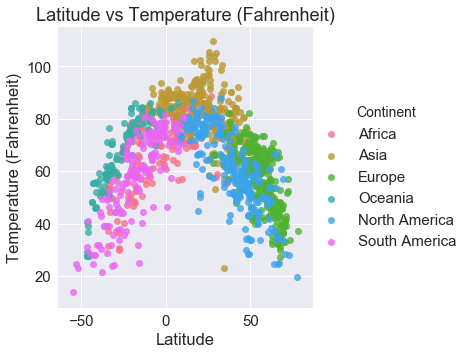

In [49]:
# -----------------------------------------------------------------------------------
# Step 5: Generate charts.
#  1) Temperature (F) vs. Latitude
#  2) Humidity (%) vs. Latitude
#  3) Cloudiness (%) vs. Latitude
#  4) Wind Speed (mph) vs. Latitude
# -----------------------------------------------------------------------------------
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Chart 1: Temperature vs Latitude
latVsTemp_plot = sns.lmplot(x='Latitude', 
                            y='Temperature (Fahrenheit)', 
                            data=cleanedWeather_df,
                            hue='Continent',
                            fit_reg=False, 
                            palette='husl')
plt.title("Latitude vs Temperature (Fahrenheit)")
plt.savefig("images/latXtemp.png")
plt.show()

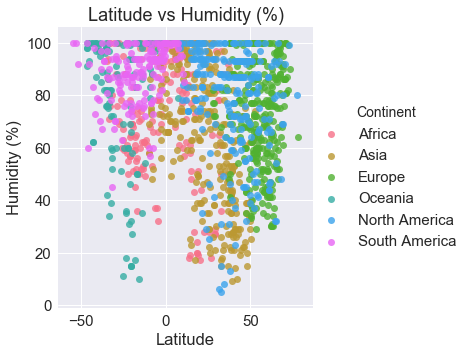

In [48]:
# Chart 2: humidity vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='Latitude', 
                            y='Humidity (%)', 
                            data=cleanedWeather_df,
                            hue='Continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Humidity (%)")
plt.savefig("images/latXhumid.png")
plt.show()

There is no relationship between latitude and humidity.

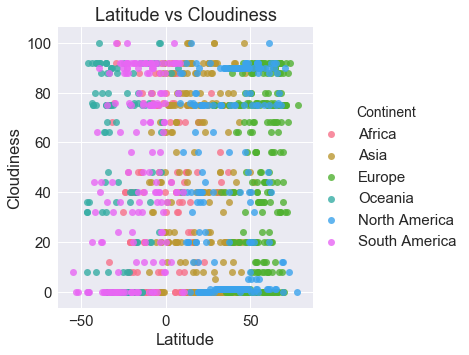

In [47]:
# Chart 3: cloudiness vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='Latitude', y='Cloudiness', 
                            data=cleanedWeather_df,
                            hue='Continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Cloudiness")
plt.savefig("images/latXcloud.png")
plt.show()

There is no relationship between latitude and cloudiness.

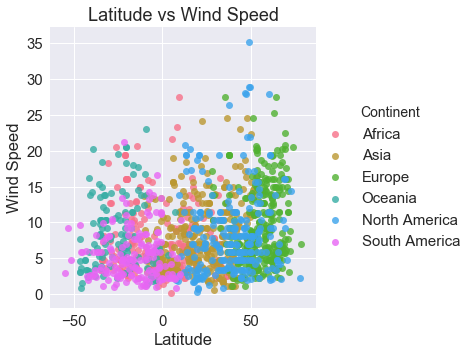

In [46]:
# Chart 4: wind speed vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='Latitude', y='Wind Speed', 
                            data=cleanedWeather_df,
                            hue='Continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Wind Speed")
plt.savefig("images/latXwind.png")
plt.show()

There is no apparent relationship between latitude and wind speed.